## E25 - 사람이 말하는 단어를 인공지능 모델로 구분해보자
### 음성과 오디오 데이터
소리는 진폭과 주파스와 위상으로 나타낼 수 있으며 주파수는 소리의 높이, 진폭은 소리의 세기에 영향을 준다.   
주파수는 Hz를 사용하며 초당 몇 회나 진동하느냐를 나타낸다. 주기는 한 번 진동하는데 걸리는 시간. 소리의 높낮이를 결정한다.  
복합파는 다양한 주파수가 섞인 소리  
오디오 데이터는 아날로그 데이터이며 컴퓨터는 디지털 데이터만 다루기 때문에 컴퓨터가 이해할 수 있게 처리가 필요하다.  

In [1]:
# 아날로그 신호의 표본화(Sampling)

import numpy as np
import matplotlib.pyplot as plt

def single_tone(frequecy, sampling_rate=16000, duration=1):
    t = np.linspace(0, duration, int(sampling_rate))
    y = np.sin(2 * np.pi * frequecy * t)
    return y

y = single_tone(400)

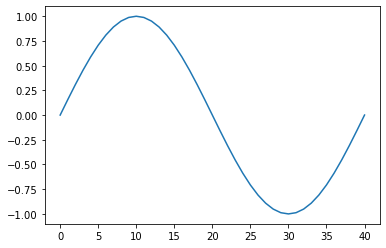

In [2]:
plt.plot(y[:41])
plt.show()

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  This is separate from the ipykernel package so we can avoid doing imports until


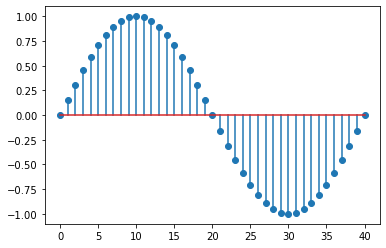

In [3]:
# 시간축 방향에서 일정 간격으로 샘플을 추출하여 이산 신호로 변환시키는 과정을 표본화(샘플링_Sampling)이라 한다.

plt.stem(y[:41])
plt.show()

Sampling rate: 초당 샘플링 횟수
Sampling: 초당 연속적인 신호를 몇 개의 숫자로 나누어 표현할 것인가

나이키스트-새넌 표본화에 따르면 speech에서는 16kHz, 음악에서는 44.1kHz 주파수 영역대  
사람의 음성을 사용하기 때문에 sampling rate는 16kHz를 사용한다.  
https://linecard.tistory.com/20  

아날로그를 디지털 신호로 변환하는 과정  
표본화(Sampling) -> 양자화(Quantizing) -> 부호화(Encoding)
양자화: 샘플링한 데이터 값을 일정한 값에 근사시킨다. 이 과정에서 원본과 왜곡이 발생할 수 있다. 샘플링 레이트가 클수록 원본에 가까운 형태가 된다.  
부호화: 0, 1의 데이터로 바꾼다.  
#### Wave data 분석  
mkdir -p ~/aiffel/speech_recognition/data  
mkdir -p ~/aiffel/speech_recognition/models  
wget http://bigfile.mail.naver.com/bigfileupload/download?fid=8QbZaAIq1NKXFoMjK3YXaxbwF3YZKAUmKxgwaxulFAMqFCYwFog9FquwFxvlHrMrpxg9KAtwFAt9K6K9F4udpx0oKxFvKxCoFq+vpo+0 -O speech_wav_8000.npz  
mv speech_wav_8000.npz ~/aiffel/speech_recognition/data  

오디오 데이터는 이미지보다는 차원이 낮으며 1차원으로 이루어진 시계열 데이터이다.  
짧은 단어에 라벨이 있어서 음성을 텍스트로 구분 가능하다  
Bits per sample: 샘플 당 소리의 세기를 몇 비트로 저장했느냐, 16bits라면 소리의 세기를 65536단계로 표현 가능  
sampling frequency: 초당 샘플링 횟수, 나이키스트 룰에 따라서 복원해야 할 신호의 두 배를 샘플링해야 한다.  
결론은 샘플링 rate가 높을수록 샘플링 하는 횟수가 많아져서 원본과 가까워지지만 데이터량은 커진다.  
channel: 2채널(Stereo)은 좌우 데이터, 1채널은 왼쪽 데이터만 있다.

In [4]:
import numpy as np
import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)


In [5]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)

# 1초 길이의 오디오 음성 데이터가 50620개
# https://www.kaggle.com/c/tensorflow-speech-recognition-challenge

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)


In [6]:
import IPython.display as ipd
import random

# 데이터 선택
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  6010
Wave data shape :  (8000,)
label :  ['left']


### Train/Test 데이터셋 구성하기
Label data 처리하기  
정답은 text 형태로 되어 있어서 학습가능한 형태로 만들어준다.

In [7]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value


In [8]:
# label를 인덱스 형태로 바꿔주기

temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)


학습을 위해 데이터 분리하기

In [9]:
from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.1,
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])


[[-4.4083826e-02 -6.4192109e-02 -6.2150490e-02 ... -6.6481590e-02
  -6.5236196e-02 -7.1700133e-02]
 [-2.5794294e-05 -7.6940698e-05 -6.5351029e-05 ... -5.4862317e-05
  -7.9142381e-05 -8.3589483e-05]
 [ 6.9461279e-03  9.2733381e-03  8.2235085e-03 ...  3.8669456e-03
   4.6589854e-03 -1.2247544e-03]
 ...
 [-1.8155315e-03 -2.1640069e-03 -1.8580791e-03 ... -7.3855737e-04
  -2.6396170e-04 -1.0543157e-03]
 [ 5.2903418e-04 -6.0433726e-04  8.7075960e-04 ... -6.3507377e-06
   8.7119850e-05  1.5338810e-04]
 [ 3.2777030e-03  4.7204634e-03  8.1363207e-05 ...  2.4862613e-03
   2.0094283e-03 -1.9644832e-03]]


In [10]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)


train data :  (45558, 8000, 1)
train labels :  (45558,)
test data :  (5062, 8000, 1)
test labels :  (5062,)


In [11]:
train_wav[0]

array([[-0.04408383],
       [-0.06419211],
       [-0.06215049],
       ...,
       [-0.06648159],
       [-0.0652362 ],
       [-0.07170013]], dtype=float32)

hyper-parameters setting

In [12]:
batch_size = 128
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel0042/aiffel/speech_recognition/models/wav'

Data setting  
tf.data.Dataset을 이용해서 데이터셋 구성하기

In [13]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label


In [14]:
import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)


<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>


Wave classification 모델 구현  
오디오 데이터는 1차원이기 때문에 conv1D layer을 사용한다.

In [15]:
from tensorflow.keras import layers

input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8000, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 8000, 32)          320       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8000, 32)          9248      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 4000, 32)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 4000, 64)          18496     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 4000, 64)          36928     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2000, 64)          0     

Loss  
12개의 클래스를 분류하기 때문에 categoricalCrossentropy loss사용한다.

In [16]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


훈련하기

In [17]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
# val_loss를 모니터링, loss가 낮아지면 모델 파라미터 저장

In [18]:
#30분 내외 소요
history_wav = model_wav.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )


Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.4634 - accuracy: 0.5174
Epoch 00001: val_loss improved from inf to 1.54792, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
355/355 [==============================] - 143s 402ms/step - loss: 1.4634 - accuracy: 0.5174 - val_loss: 1.5479 - val_accuracy: 0.5026
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.7485
Epoch 00002: val_loss improved from 1.54792 to 0.81006, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
355/355 [==============================] - 143s 402ms/step - loss: 0.8297 - accuracy: 0.7485 - val_loss: 0.8101 - val_accuracy: 0.7440
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.6159 - accuracy: 0.8190
Epoch 00003: val_loss improved from 0.81006 to 0.61857, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav
355/355 [==============================] - 143s 402ms/step - loss: 0

학습 결과 시각화하기

In [18]:
import matplotlib.pyplot as plt

acc = history_wav.history['accuracy']
val_acc = history_wav.history['val_accuracy']

loss=history_wav.history['loss']
val_loss=history_wav.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history_wav' is not defined

Evaluation  
test셋을 이용하여 모델 성능 평가하기

In [19]:
# 저장된 weight 불러와서 테스트 해보기

model_wav.load_weights(checkpoint_dir)


In [20]:
results = model_wav.evaluate(test_dataset)


40/40 [==============================] - 9s 235ms/step - loss: 0.1182 - accuracy: 0.9735


In [21]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


loss value: 0.118
accuracy value: 97.3528%


Model Test  
testset에서 직접 들어보고 모델의 예측이 맞는지 확인해보기

In [22]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  right


In [23]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))


y_pred: right


Skip-Connection model 추가하기

In [24]:
input_tensor = layers.Input(shape=(sr, 1))

x = layers.Conv1D(32, 9, padding='same', activation='relu')(input_tensor)
x = layers.Conv1D(32, 9, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool1D()(x)

x = layers.Conv1D(64, 9, padding='same', activation='relu')(skip_1)
x = layers.Conv1D(64, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool1D()(x)

x = layers.Conv1D(128, 9, padding='same', activation='relu')(skip_2)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(128, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool1D()(x)

x = layers.Conv1D(256, 9, padding='same', activation='relu')(skip_3)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = layers.Conv1D(256, 9, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool1D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8000, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 8000, 32)     320         input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 8000, 32)     9248        conv1d_10[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_4 (MaxPooling1D)  (None, 4000, 32)     0           conv1d_11[0][0]                  
____________________________________________________________________________________________

In [25]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])


In [26]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [28]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
355/355 [==============================] - ETA: 0s - loss: 1.2963 - accuracy: 0.5842
Epoch 00001: val_loss improved from inf to 1.23112, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 168s 473ms/step - loss: 1.2963 - accuracy: 0.5842 - val_loss: 1.2311 - val_accuracy: 0.6607
Epoch 2/10
355/355 [==============================] - ETA: 0s - loss: 0.7262 - accuracy: 0.7899
Epoch 00002: val_loss improved from 1.23112 to 0.70392, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 168s 474ms/step - loss: 0.7262 - accuracy: 0.7899 - val_loss: 0.7039 - val_accuracy: 0.7855
Epoch 3/10
355/355 [==============================] - ETA: 0s - loss: 0.4918 - accuracy: 0.8702
Epoch 00003: val_loss improved from 0.70392 to 0.51410, saving model to /home/aiffel0042/aiffel/speech_recognition/models/wav_skip
355/355 [==============================] - 168s 474ms

In [27]:
import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


NameError: name 'history_wav_skip' is not defined

In [28]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))


40/40 [==============================] - 6s 154ms/step - loss: 0.1130 - accuracy: 0.9739
loss value: 0.113
accuracy value: 97.3923%


In [29]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

label :  stop


In [30]:
if np.argmax(y_pred_) == test_label[i]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]))


y_pred: stop


### Spectrogram
wave파일은 다양한 파형이 합성된 복합파  
주파수 대역별로 분리해 볼 수 있다, 푸리에 변환 사용  

푸리에변환(Fourier transform): 임의의 입력 신호를 다양한 주파수를 갖는 주기함수들이 합으로 분해하여 표현하는 것  
즉, 푸리에변환은 입력 신호가 어떤 것인지 상관없이 sin, cos과 같은 주기함수들의 합으로 항상 분해가 가능하다.  
푸리에변환이 끝나면 실수부와 허수부로 이루어진 복소수을 얻을 수 있다.  
이 때 복소수의 절대값은 spectrum magnitude(주파수의 강도)라고 하고,  
복소수가 가지는 phase는 phase spectrum(주파수의 위상)이라 한다.  
STFT(Short Time Fourier Transform): 시간의 길이를 나눠서 퓨리에 변환  

spectrogram: wave데이터를 해석하는 방법 중 하나며, 일정 시간동안 wave 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는지 보여준다.  

In [31]:
import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D


In [32]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


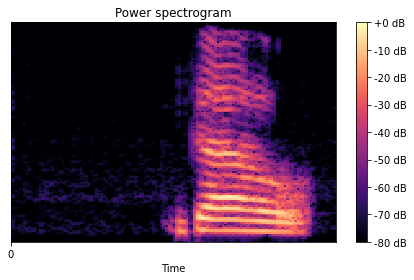

In [33]:
import librosa.display

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()